**Necessary Imports**

In [ ]:
###
import tensorflow as tf
#import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import glob
import shutil
import pathlib
import random

#model selection
from sklearn.model_selection import train_test_split

#data augumentation
import  cv2
import imgaug
import imageio
from imgaug import augmenters as iaa

##
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.applications import VGG19
from keras.layers import Dense, GlobalMaxPool2D, BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

from tensorflow.keras import layers
from tensorflow.keras.models import load_model

In [ ]:
print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.12.0


**Drive Mount**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_path = '/content/drive/MyDrive/ThesisExperimentsFinal/FineTunedandCostSensitive/Vgg19/Model/'
save_path1 = '/content/drive/MyDrive/ThesisExperimentsFinal/FineTunedandCostSensitive/Vgg19/Weight/'

In [ ]:
#Run from here
import os
x_train = []
y_train = []
x_train = np.load("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/TrainData.npy")
y_train = np.load("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/TrainLabels.npy")

x_val = []
y_val = []
x_val = np.load("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/ValData.npy")
y_val = np.load("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/ValLabels.npy")

x_test = []
y_test = []
x_test = np.load("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/TestData.npy")
y_test = np.load("/content/drive/MyDrive/ThesisExperimentsFinal/Dataset/FinalData/TestLabels.npy")

print(f"x_train shape: {x_train .shape} - y_train shape: {y_train .shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test .shape}")

x_train shape: (18123, 110, 110, 3) - y_train shape: (18123,)
x_val shape: (648, 110, 110, 3) - y_val shape: (648,)
x_test shape: (812, 110, 110, 3) - y_test shape: (812,)


In [ ]:
def VGG(seed = None):
    np.random.seed(seed)
    vgg19 = VGG19(weights="imagenet", include_top=False)
    for layer in vgg19.layers[:17]:
        layer.trainable = False
    for layer in vgg19.layers[17:]:
        layer.trainable = True
    y = (vgg19.get_layer("block5_conv2")).output
    mx_y = GlobalMaxPool2D()(y)
    x = BatchNormalization()(mx_y)
    x = Dropout(.5)(x)
    x = Dense(1024, activation='relu', name="dense_1024")(x)
    x = BatchNormalization()(x)
    x = Dropout(.5)(x)
    preds = Dense(5,activation='softmax')(x)
    model = Model(inputs=vgg19.input, outputs=preds)
    return model

**Training Models**

# **Fine Tunning**

In [ ]:
model_vgg19 = VGG()

epochs = 50
opt = Adam(learning_rate=1e-3)
model_vgg19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

80134624/80134624 [==============================] - 2s 0us/step


In [ ]:
model_vgg19.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/model_vgg19.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=1e-5)
callbacks=[reduce_lr, checkpointer]

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical


y_train_one_hot = to_categorical(y_train, num_classes=5)
y_val_one_hot = to_categorical(y_val, num_classes=5)


In [ ]:
trainVgg19FT = model_vgg19.fit(x=x_train, y=y_train_one_hot, validation_data=(x_val,y_val_one_hot), epochs=50, callbacks=callbacks)

Epoch 1/50
567/567 [==============================] - ETA: 0s - loss: 0.8944 - accuracy: 0.7184
Epoch 1: val_accuracy improved from -inf to 0.87963, saving model to saved_models/model_vgg19.hdf5
567/567 [==============================] - 40s 51ms/step - loss: 0.8944 - accuracy: 0.7184 - val_loss: 0.3497 - val_accuracy: 0.8796 - lr: 0.0010
Epoch 2/50
567/567 [==============================] - ETA: 0s - loss: 0.4732 - accuracy: 0.8365
Epoch 2: val_accuracy improved from 0.87963 to 0.89352, saving model to saved_models/model_vgg19.hdf5
567/567 [==============================] - 28s 49ms/step - loss: 0.4732 - accuracy: 0.8365 - val_loss: 0.3657 - val_accuracy: 0.8935 - lr: 0.0010
Epoch 3/50
566/567 [============================>.] - ETA: 0s - loss: 0.3740 - accuracy: 0.8682
Epoch 3: val_accuracy improved from 0.89352 to 0.91667, saving model to saved_models/model_vgg19.hdf5
567/567 [==============================] - 29s 50ms/step - loss: 0.3740 - accuracy: 0.8682 - val_loss: 0.2585 - val_a

Saving Model in GDrive

In [ ]:
model_vgg19.save(save_path + 'FineTunedVGG19.h5')
#model_vgg16.save_weights(save_path1 + "Weights_FineTunedVGG16.h5")


In [ ]:
y_test_one_hot = to_categorical(y_test, num_classes=5)
accuracy = model_vgg19.evaluate(x_test, y_test_one_hot)[1]

26/26 [==============================] - 2s 66ms/step - loss: 0.2802 - accuracy: 0.9421


Evaluating Model

In [ ]:
from tensorflow.keras.models import load_model
FT_VGG19= load_model(save_path + 'FineTunedVGG19.h5')


26/26 [==============================] - 1s 40ms/step


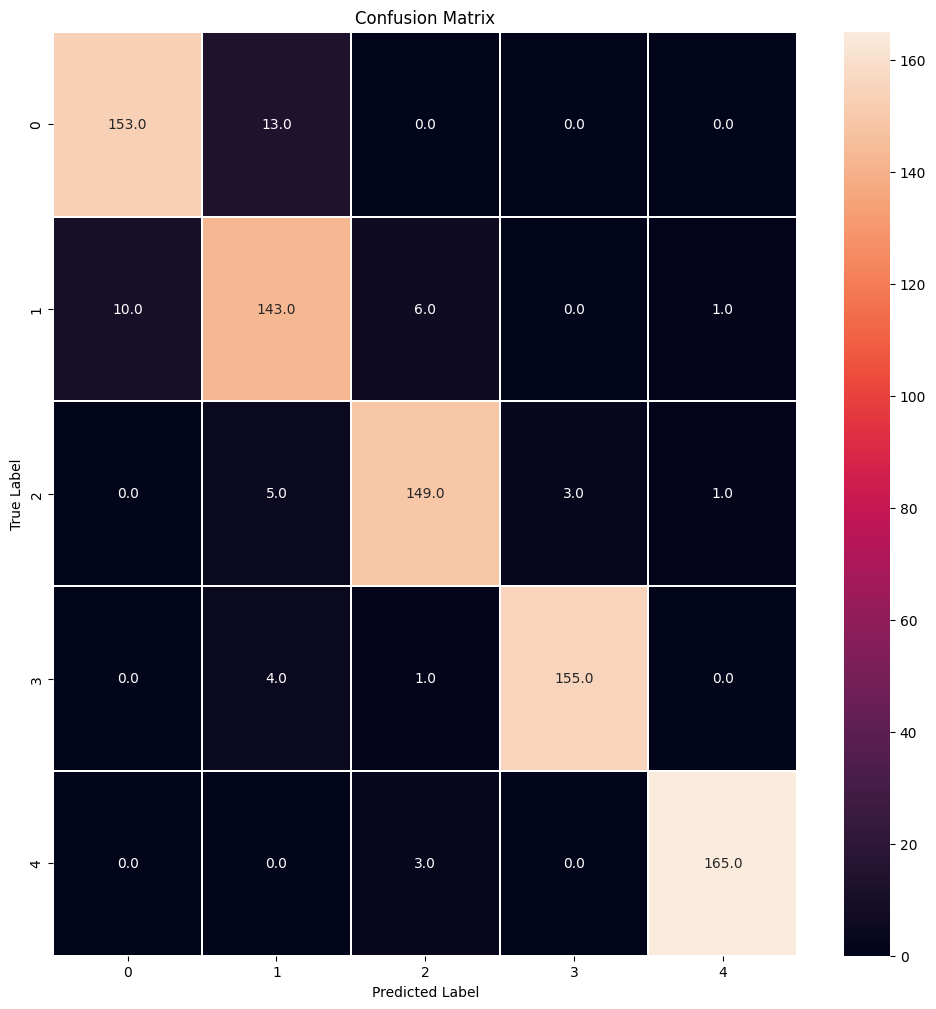

In [ ]:
cancer_classes=np.unique(y_test)
pred = FT_VGG19.predict(x_test)

y_pred = np.argmax(pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, y_test)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(cancer_classes)
ax.yaxis.set_ticklabels(cancer_classes)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report1 = classification_report(y_test, y_pred, target_names=cancer_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
0,0.921687,0.938650,0.930091,163.000000
1,0.893750,0.866667,0.880000,165.000000
2,0.943038,0.937107,0.940063,159.000000
3,0.968750,0.981013,0.974843,158.000000
4,0.982143,0.988024,0.985075,167.000000
accuracy,0.942118,0.942118,0.942118,0.942118
macro avg,0.941874,0.942292,0.942014,812.000000
weighted avg,0.941782,0.942118,0.941881,812.000000


# Cost Sensitive

In [ ]:
from sklearn.utils import class_weight

class_weights = dict(zip(np.unique(y_test), class_weight.compute_class_weight('balanced', classes = np.unique(y_test),
                                        y = y_test))) 

class_weights

{0: 0.996319018404908,
 1: 0.9842424242424243,
 2: 1.0213836477987421,
 3: 1.0278481012658227,
 4: 0.9724550898203593}

In [ ]:
modelCS_VGG19=load_model(save_path + 'FineTunedVGG19.h5')
epochs = 50
opt = Adam(learning_rate=1e-3)
modelCS_VGG19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/modelCS_VGG19_CS.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=1e-5)
callbacks=[early_stopping,reduce_lr, checkpointer]

In [ ]:
modelCS_VGG19.fit(x=x_train, y=y_train_one_hot, validation_data=(x_val, y_val_one_hot), epochs=50, class_weight=class_weights,callbacks=callbacks)

Epoch 1/50
567/567 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 0.9962
Epoch 1: val_accuracy did not improve from 0.93056
567/567 [==============================] - 28s 50ms/step - loss: 0.0118 - accuracy: 0.9962 - val_loss: 0.3589 - val_accuracy: 0.9290 - lr: 1.0000e-05
Epoch 2/50
566/567 [============================>.] - ETA: 0s - loss: 0.0122 - accuracy: 0.9958
Epoch 2: val_accuracy did not improve from 0.93056
567/567 [==============================] - 28s 50ms/step - loss: 0.0122 - accuracy: 0.9958 - val_loss: 0.3610 - val_accuracy: 0.9275 - lr: 1.0000e-05
Epoch 3/50
566/567 [============================>.] - ETA: 0s - loss: 0.0118 - accuracy: 0.9959
Epoch 3: val_accuracy did not improve from 0.93056
567/567 [==============================] - 28s 49ms/step - loss: 0.0118 - accuracy: 0.9959 - val_loss: 0.3646 - val_accuracy: 0.9275 - lr: 1.0000e-05
Epoch 4/50
567/567 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9956
Epoch 4: val_

In [ ]:
modelCS_VGG19.save(save_path + 'FTCS_VGG19.h5')
#modelCS_VGG16.save_weights(save_path1 + "Weights_FTCS_VGG16.h5")


In [ ]:
y_test_one_hot = to_categorical(y_test, num_classes=5)
accuracy = modelCS_VGG19.evaluate(x_test, y_test_one_hot)[1]

26/26 [==============================] - 1s 41ms/step - loss: 0.3435 - accuracy: 0.9409


In [ ]:
CS_VGG19= load_model(save_path + 'FTCS_VGG19.h5')

26/26 [==============================] - 1s 41ms/step


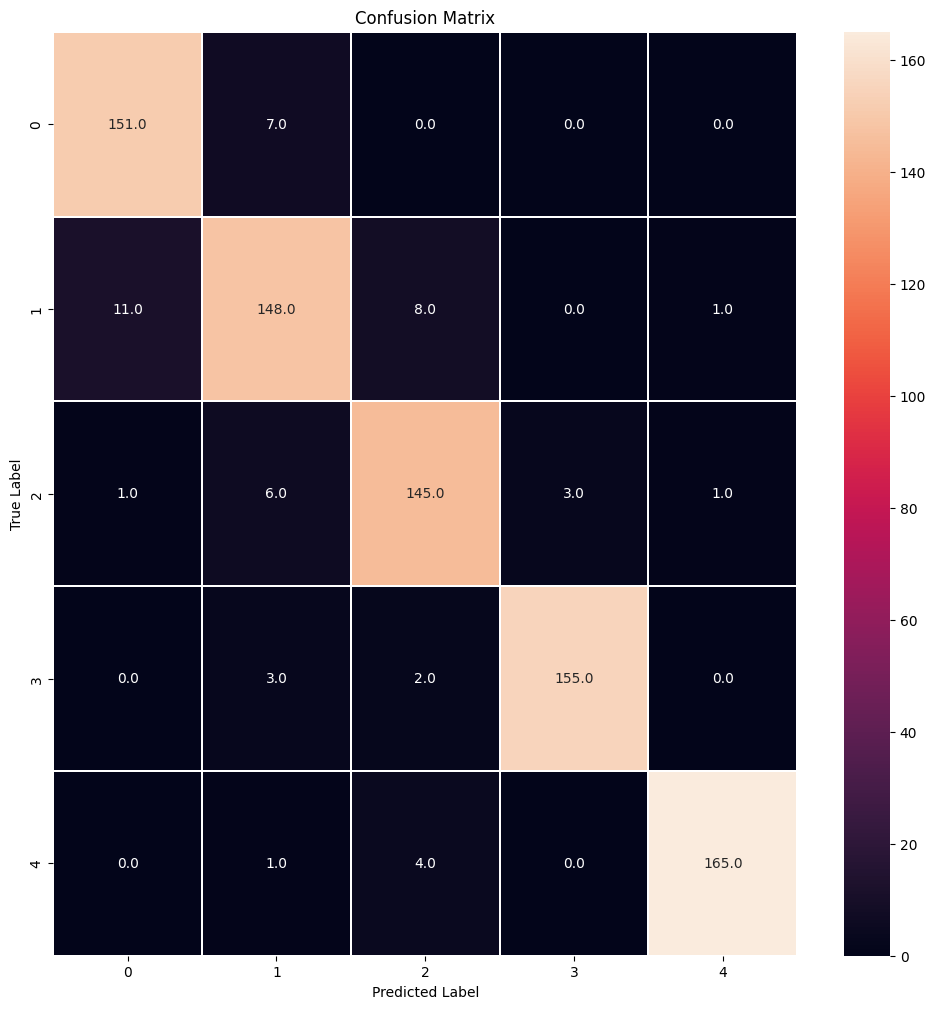

In [ ]:
cancer_classes=np.unique(y_test)
pred = CS_VGG19.predict(x_test)

y_pred = np.argmax(pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, y_test)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(cancer_classes)
ax.yaxis.set_ticklabels(cancer_classes)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
report12 = classification_report(y_test, y_pred, target_names=cancer_classes, output_dict=True)
df12 = pd.DataFrame(report12).transpose()
df12

,precision,recall,f1-score,support
0,0.955696,0.926380,0.940810,163.000000
1,0.880952,0.896970,0.888889,165.000000
2,0.929487,0.911950,0.920635,159.000000
3,0.968750,0.981013,0.974843,158.000000
4,0.970588,0.988024,0.979228,167.000000
accuracy,0.940887,0.940887,0.940887,0.940887
macro avg,0.941095,0.940867,0.940881,812.000000
weighted avg,0.940979,0.940887,0.940832,812.000000
